In [1]:
import numpy as np
from keras.utils.io_utils import HDF5Matrix
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image
from keras.utils import Sequence
from keras.backend import epsilon
import keras.backend as K
from keras.optimizers import Adam
from keras.regularizers import l2
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageEnhance
from keras.applications.nasnet import NASNetMobile, preprocess_input
from keras.layers import *
from keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

BATCH_SIZE = 32
IMAGE_SIZE = 224
ALPHA = 0.75
EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20
DATA_DIR = 'images/'

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_data = HDF5Matrix('../images.h5','images',0,1)

In [3]:
x = X_data.data

In [4]:
a = x.value

In [5]:
a.shape

(24000, 224, 224, 3)

In [6]:
y_data = HDF5Matrix('../coords.h5','coords',start=1,end=10)

In [7]:
y = y_data.data

In [8]:
y = y.value

In [9]:
y.shape

(24000, 4)

In [10]:
X = a
a = None

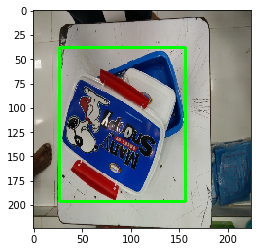

In [11]:
img = X[0].copy()
x0,y0,x1,y1 = y[0].copy()
x1 = x0 + x1
y1 = y0 + y1
cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)),(0, 255, 0), 2)
plt.imshow(img)

In [12]:
y[0]

array([ 27.3       ,  38.73333333, 128.8       , 158.2       ])

In [13]:
class DataGenerator(Sequence):
    def __init__(self, images, coords, rnd_rescale=True, rnd_multiply=True, rnd_color=True, rnd_crop=True, rnd_flip=True,
                 batch_size = BATCH_SIZE):
        self.images = images
        self.coords = coords
        self.batch_size = batch_size
        self.rnd_rescale = rnd_rescale
        self.rnd_multiply = rnd_multiply
        self.rnd_color = rnd_color
        self.rnd_crop = rnd_crop
        self.rnd_flip = rnd_flip
        
    def __len__(self):
        return len(self.coords)//self.batch_size
    
    def random_rescale(self, img, coords, low = 0.6, high = 1.4):
      img_width = img.width
      img_height = img.height
      scale_ratio = np.random.uniform(low = low, high = high)
      new_width, new_height = int(img_width*scale_ratio), int(img_height*scale_ratio)
      img = img.resize((new_width, new_height))
      x0, y0, x1, y1 = coords
      x0 = x0*new_width/img_width
      y0 = y0*new_height/img_height
      x1 = x1*new_width/img_width
      y1 = y1*new_height/img_height
      
      return img, x0, y0, x1, y1
    
    def random_crop(self, img, coords, crop_ratio = 0.15):
      img_width, img_height = img.width, img.height
      new_x0 = np.random.randint(low = 0, high = int(crop_ratio*img_width))
      new_y0 = np.random.randint(low = 0, high = int(crop_ratio*img_height))
      
      new_x1 = img_width - np.random.randint(low = 0, high = int(crop_ratio*img_width))
      new_y1 = img_height - np.random.randint(low = 0, high = int(crop_ratio*img_height))
      
      img = img.crop((new_x0, new_y0, new_x1, new_y1))
      
      x0, y0, x1, y1 = coords
      x0 = max(x0 - new_x0, 0)
      y0 = max(y0 - new_y0, 0)
      x1 = min(x1 - new_x0, img_width)
      y1 = min(y1 - new_y0, img_height)
      return img, x0, y0, x1, y1
    
    def random_flip(self, img, coords):
      img_width, img_height = img.width, img.height
      x0, y0, x1, y1 = coords
      '''
      Flip types: [0, 90, 180, 270, 1423, 1234]
      0: 0 degree rotation (no change in original image)
      90: 90 degree rotation 
      180: 180 degree rotation
      270: 270 degree rotation
      1423: Top bottom flip (mirror image over a horizontal line passing through the center)
      1234: Left right flip (mirrot image over a vertical line passing though the center)
      '''
      
      #Choosing what type of flip to perform randomly
      flip_type = np.random.choice([0, 90, 180, 270, 1423, 1234])
      if flip_type in [0, 90, 180, 270]:
        
        x = x0 - img_width / 2
        y = y0 - img_height / 2

        x0 = img_width / 2 + x * np.cos(np.deg2rad(flip_type)) - y * np.sin(np.deg2rad(flip_type))
        y0 = img_height / 2 + x * np.sin(np.deg2rad(flip_type)) + y * np.cos(np.deg2rad(flip_type))

        x = x1 - img_width / 2
        y = y1 - img_height / 2

        x1 = img_width / 2 + x * np.cos(np.deg2rad(flip_type)) - y * np.sin(np.deg2rad(flip_type))
        y1 = img_height / 2 + x * np.sin(np.deg2rad(flip_type)) + y * np.cos(np.deg2rad(flip_type))
        
      else:
        
        if flip_type == 1423:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            y0 = img_height - y0
            y1 = img_height - y1

        elif flip_type == 1234:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            x0 = img_width - x0
            x1 = img_width - x1
              
      return img, x0, y0, x1, y1
    
    
    def random_color(self, img):
      color_enhancer = ImageEnhance.Color(img)
      img = color_enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

      brightness_enhancer = ImageEnhance.Brightness(img)
      img = brightness_enhancer.enhance(np.random.uniform(low=0.7, high=1.3))
      return img
    
    def random_multiply(self, img, low = 0.8, high = 1.2):
      img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=low, high=high), 0.0, 255.0))
      img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=low, high=high), 0.0, 255.0))
      img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=low, high=high), 0.0, 255.0))     
      return img
    
    def __getitem__(self, idx):
        batch_ids = np.arange(idx * self.batch_size, (idx + 1) * self.batch_size)
        coords = self.coords[idx * self.batch_size : (idx + 1) * self.batch_size].copy()
        batch_coords = np.zeros((self.batch_size,4))
        batch_images = np.zeros((len(batch_ids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

        for i, f in enumerate(batch_ids):
            img = self.images[f].copy()
            img = Image.fromarray(img.astype('uint8'), 'RGB')
            x0,y0,x1,y1 = coords[i]
            x1 = x0 + x1
            y1 = y0 + y1
            if self.rnd_rescale:
                old_width = img.width
                old_height = img.height

                rescale = np.random.uniform(low=0.6, high=1.4)
                new_width = int(old_width * rescale)
                new_height = int(old_height * rescale)

                img = img.resize((new_width, new_height))

                x0 *= new_width / old_width
                y0 *= new_height / old_height
                x1 *= new_width / old_width
                y1 *= new_height / old_height

            if self.rnd_crop:
                start_x = np.random.randint(0, high=np.floor(0.15 * img.width))
                stop_x = img.width - np.random.randint(0, high=np.floor(0.15 * img.width))
                start_y = np.random.randint(0, high=np.floor(0.15 * img.height))
                stop_y = img.height - np.random.randint(0, high=np.floor(0.15 * img.height))

                img = img.crop((start_x, start_y, stop_x, stop_y))

                x0 = max(x0 - start_x, 0)
                y0 = max(y0 - start_y, 0)
                x1 = min(x1 - start_x, img.width)
                y1 = min(y1 - start_y, img.height)

                if np.abs(x1 - x0) < 5 or np.abs(y1 - y0) < 5:
                    print("\nWarning: cropped too much (obj width {}, obj height {}, img width {}, img height {})\n".format(x1 - x0, y1 - y0, img.width, img.height))

            if self.rnd_flip:
                elem = np.random.choice([0, 90, 180, 270, 1423, 1234])
                if elem % 10 == 0:
                    x = x0 - img.width / 2
                    y = y0 - img.height / 2

                    x0 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y0 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    x = x1 - img.width / 2
                    y = y1 - img.height / 2

                    x1 = img.width / 2 + x * np.cos(np.deg2rad(elem)) - y * np.sin(np.deg2rad(elem))
                    y1 = img.height / 2 + x * np.sin(np.deg2rad(elem)) + y * np.cos(np.deg2rad(elem))

                    img = img.rotate(-elem)
                else:
                    if elem == 1423:
                        img = img.transpose(Image.FLIP_TOP_BOTTOM)
                        y0 = img.height - y0
                        y1 = img.height - y1

                    elif elem == 1234:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                        x0 = img.width - x0
                        x1 = img.width - x1

            image_width = img.width
            image_height = img.height

            tmp = x0
            x0 = min(x0, x1)
            x1 = max(tmp, x1)

            tmp = y0
            y0 = min(y0, y1)
            y1 = max(tmp, y1)

            x0 = max(x0, 0)
            y0 = max(y0, 0)

            y0 = min(y0, image_height)
            x0 = min(x0, image_width)
            y1 = min(y1, image_height)
            x1 = min(x1, image_width)

            if self.rnd_color:
                enhancer = ImageEnhance.Color(img)
                img = enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

                enhancer2 = ImageEnhance.Brightness(img)
                img = enhancer.enhance(np.random.uniform(low=0.7, high=1.3))

            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')
            pil_img = img
            img = np.array(img, dtype=np.float32)
            pil_img.close()
            if self.rnd_multiply:
                img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))
                img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=0.8, high=1.2), 0.0, 255.0))

            batch_images[i] = preprocess_input(img.copy())
            
            batch_coords[i, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height 

        return batch_images, batch_coords


In [14]:
train_loader = DataGenerator(X, y)# False, False, False, False, False)

In [15]:
imgs, coords = train_loader.__getitem__(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


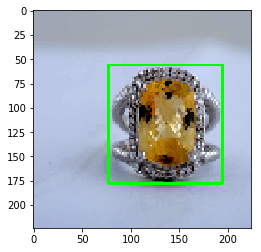

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


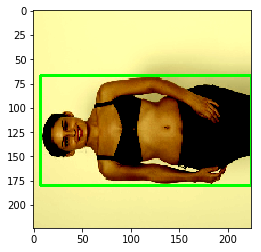

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


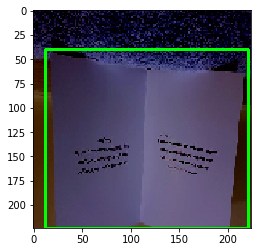

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


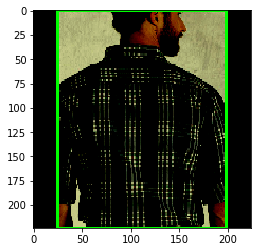

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


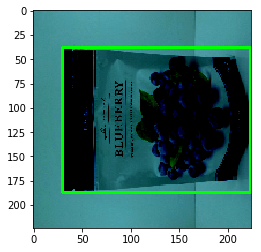

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


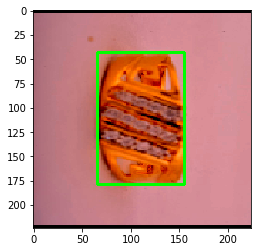

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


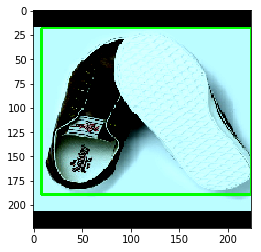

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


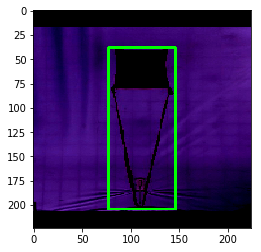

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


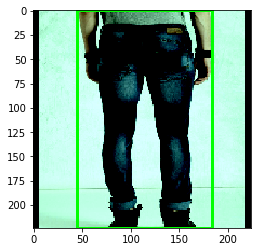

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


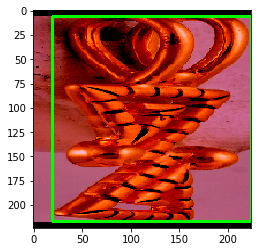

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


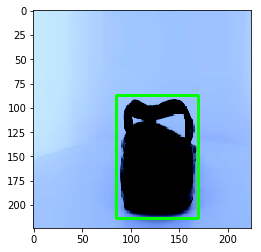

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


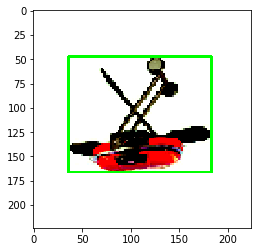

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


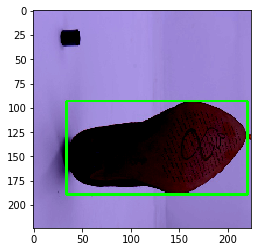

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


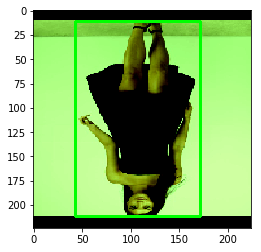

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


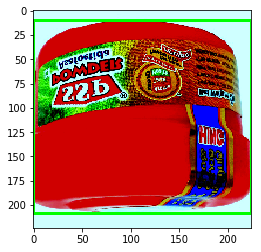

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


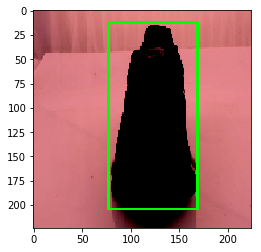

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


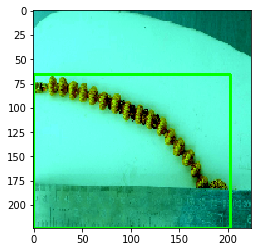

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


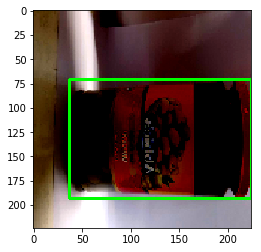

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


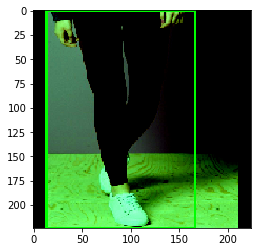

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


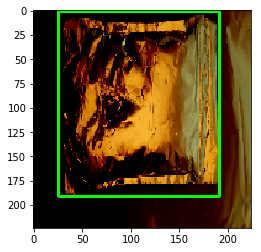

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


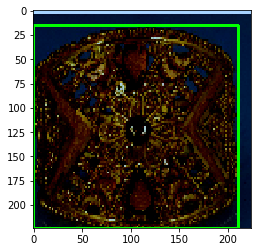

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


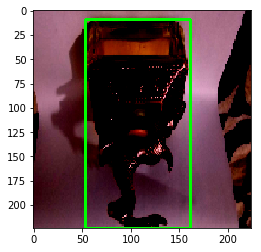

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


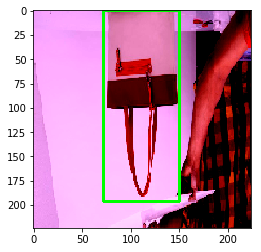

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


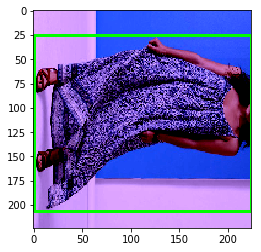

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


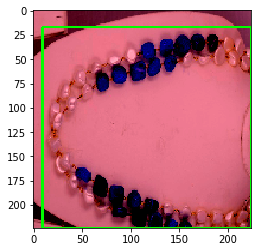

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


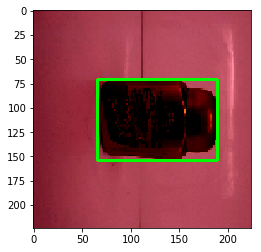

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


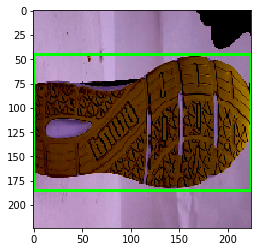

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


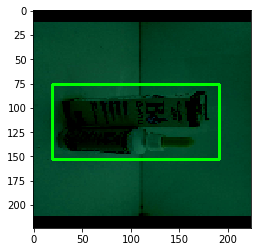

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


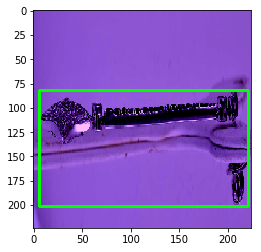

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


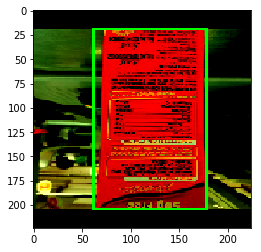

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


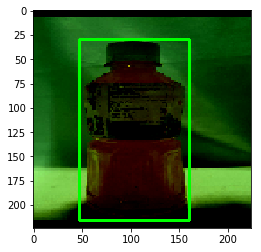

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


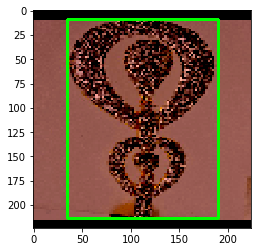

In [16]:
for i in range(32):
    img = imgs[i].copy()
    x0,y0,x1,y1 = coords[i].copy()
    x1 = x0 + x1
    y1 = y0 + y1
    cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)),(0, 255, 0), 2)
    plt.imshow(img)
    plt.show()

In [17]:
def IOU(y_true, y_pred):
    diff_width = K.minimum(y_true[:,0] + y_true[:,2], y_pred[:,0] + y_pred[:,2]) - K.maximum(y_true[:,0], y_pred[:,0])
    diff_height = K.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3]) - K.maximum(y_true[:,1], y_pred[:,1])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = K.maximum(area_gt + area_pred - intersection, 0)

    #ntersection = K.sum(intersection * (union > 0))
    intersection = K.tf.where(union > 0, intersection, K.zeros_like(intersection))
    intersection = K.sum(intersection)
    union = K.sum(union)
    iou = (intersection / (union + epsilon()))
    return iou

In [18]:
from keras.applications.mobilenet_v2 import preprocess_input

valData = pd.read_csv('validation.csv')

val_coords = np.zeros((len(valData),4))
val_images = np.zeros((len(valData), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for index, row in valData.iterrows():
    path = os.path.join(DATA_DIR, row['image_name'])
    x1 = row['x1']
    x2 = row['x2']
    y1 = row['y1']
    y2 = row['y2']

    img = Image.open(path)
    width, height = img.size

    val_coords[index, 0] = x1*IMAGE_SIZE / width
    val_coords[index, 1] = y1*IMAGE_SIZE / height
    val_coords[index, 2] = (x2 - x1)* IMAGE_SIZE / width
    val_coords[index, 3] = (y2 - y1)*IMAGE_SIZE / height 
    
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    pil_img = img
    img = np.array(img, dtype=np.float32)
    val_images[index] = preprocess_input(img.copy())
    pil_img.close()

class ValDataGenerator(Sequence):
    def __init__(self, val_images, val_coords, batch_size = BATCH_SIZE):
        self.images = val_images
        self.coords = val_coords
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_images, batch_coords

In [19]:
valgen = ValDataGenerator(val_images, val_coords)

In [20]:
imgs, coords = valgen.__getitem__(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


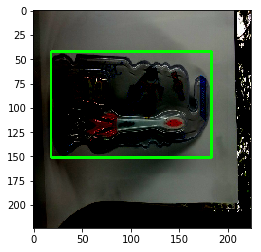

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


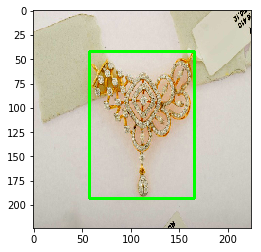

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


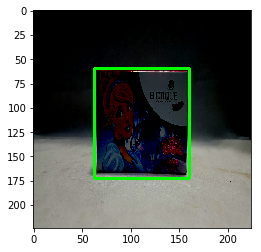

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


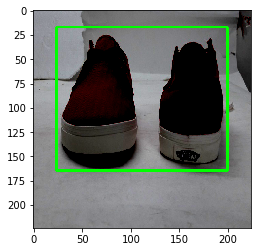

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


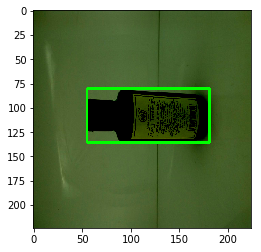

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


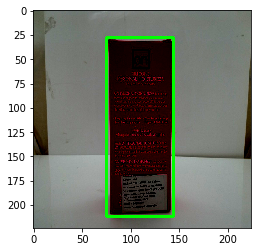

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


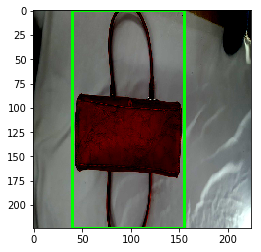

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


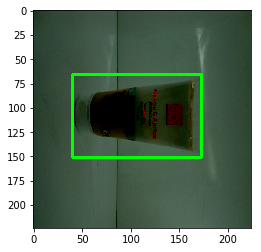

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


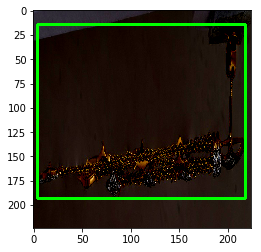

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


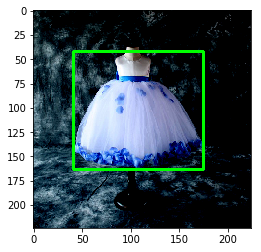

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


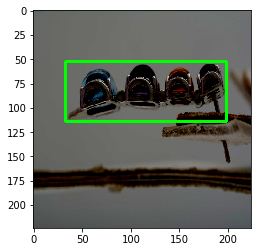

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


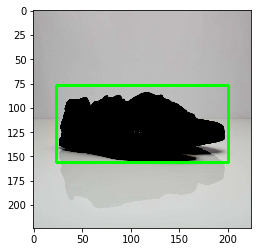

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


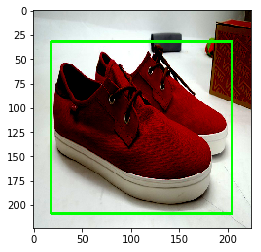

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


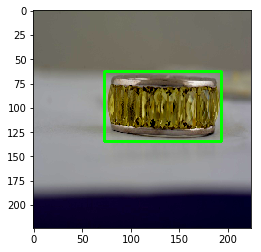

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


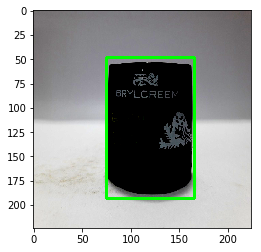

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


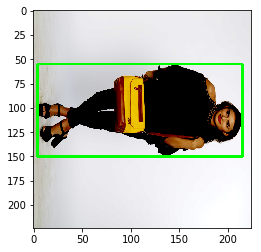

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


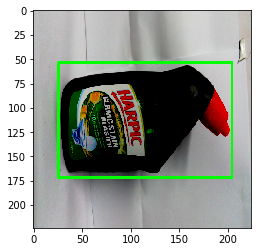

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


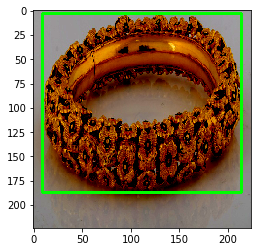

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


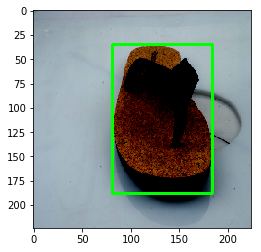

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


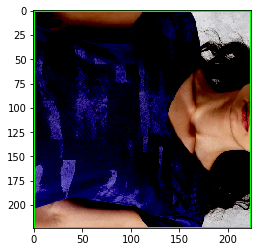

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


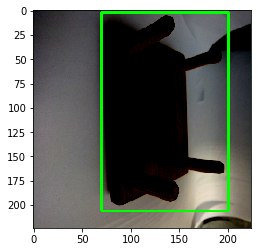

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


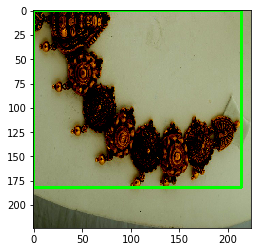

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


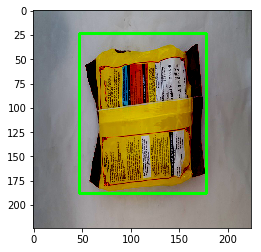

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


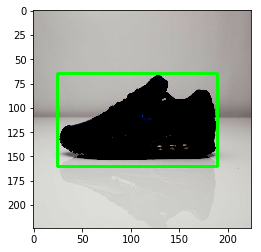

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


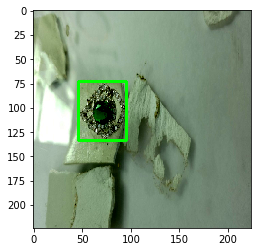

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


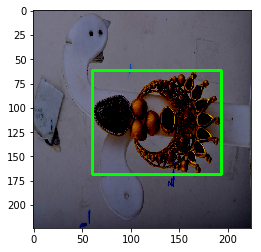

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


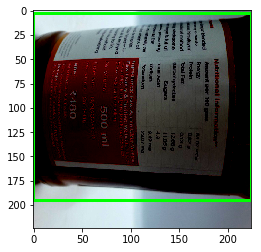

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


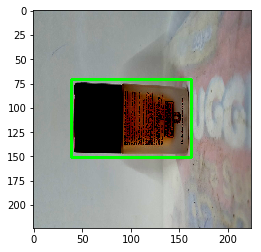

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


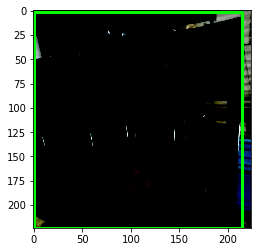

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


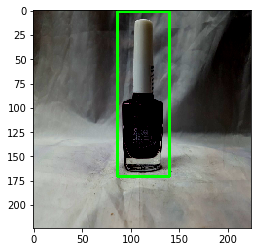

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


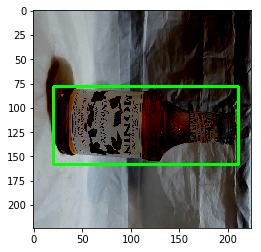

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


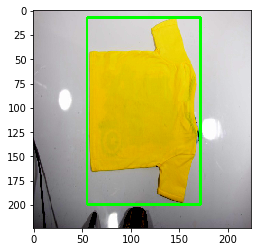

In [21]:
for i in range(32):
    img = imgs[i].copy()
    x0,y0,x1,y1 = coords[i].copy()
    x1 = x0 + x1
    y1 = y0 + y1
    cv2.rectangle(img, (int(x0), int(y0)), (int(x1), int(y1)),(0, 255, 0), 2)
    plt.imshow(img)
    plt.show()

In [22]:
def nasnet_model(trainable=True):
    model = NASNetMobile(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet',pooling = 'avg')

    for layer in model.layers:
        layer.trainable = trainable

    x = model.layers[-1].output
    x = Dense(4,activation = 'relu')(x)
    #x = Conv2D(256, kernel_size=3, name="mn1", activation='relu')(x)
    #x = Conv2D(4, kernel_size=5, name="mn2", activation='relu')(x)
    x = Reshape((4,))(x)

    return Model(inputs=model.input, outputs=x)

In [23]:
mnv2 = nasnet_model()
mnv2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

In [24]:
mnv2.compile(loss="mean_absolute_error", optimizer="adam", metrics=['accuracy',IOU])

checkpoint = ModelCheckpoint("mobilenetv2-{val_IOU:.2f}.h5", monitor="val_IOU", verbose=1, save_best_only=True, save_weights_only=True, mode="max", period=1)

stop = EarlyStopping(monitor="val_IOU", patience=PATIENCE, mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_IOU", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

In [25]:
train_datagen = DataGenerator(X, y)
validation_datagen = ValDataGenerator(val_images, val_coords)

In [26]:
mnv2.fit_generator(generator=train_datagen,
                    validation_data=validation_datagen, 
                    epochs=EPOCHS,
                    callbacks=[reduce_lr, stop, checkpoint],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/500


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 565, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 548, in <lambda>
    initargs=(seqs,))
  File "/usr/lib/python3.5/multiprocessing/context.py", line 118, in Pool
    context=self.get_context())
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 168, in __init__
    self._repopulate_pool()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 233, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.5/multiprocessing/cont

  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multipr

KeyboardInterrupt: 